# **Transformers 모델 실습**

다양한 유형의 Transformer 기반 모델을 간단히 살펴봅시다.

1. **ViT (Vision Transformer)** - 이미지 분류 (인코더)
2. **BERT** - 문장 분류 (인코더)
3. **GPT-2** - 텍스트 생성 (디코더)
4. **DETR** - 객체 검출 (인코더-디코더)

## 0. 설치(필요 시)

```bash
!pip install transformers torch torchvision matplotlib pillow
```

> 위 명령어는 Colab 환경에서 한 번만 실행하면 됩니다.
> 이미 설치되어 있다면 생략해도 됩니다.

In [1]:
!pip install transformers torch torchvision matplotlib pillow --quiet

## 1. 라이브러리 임포트 & 환경 설정

추가적으로 필요할 수 있는 라이브러리를 임포트합니다.

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

from transformers import (
    ViTImageProcessor, ViTForImageClassification,
    AutoTokenizer, AutoModelForSequenceClassification,
    GPT2LMHeadModel, GPT2Tokenizer,
    DetrImageProcessor, DetrForObjectDetection,
    pipeline
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# 2. ViT (Vision Transformer)

ViT는 이미지 분류에 특화된 인코더 모델입니다.
여기서는 사전 학습된 `google/vit-base-patch16-224` 모델을 사용해봅니다.

### 구성 순서
1. 모델과 Image Processor(ViTImageProcessor) 로드
2. 테스트할 이미지 가져오기(온라인 URL 사용)
3. 전처리 후 추론
4. Top-5 결과 출력 및 바 차트 시각화
5. 원본 이미지와 Top-1 예측 결과 시각화

mountain bike, all-terrain bike, off-roader | 점수: 0.6655
bicycle-built-for-two, tandem bicycle, tandem | 점수: 0.2919
tricycle, trike, velocipede | 점수: 0.0111
knee pad                  | 점수: 0.0048
unicycle, monocycle       | 점수: 0.0046


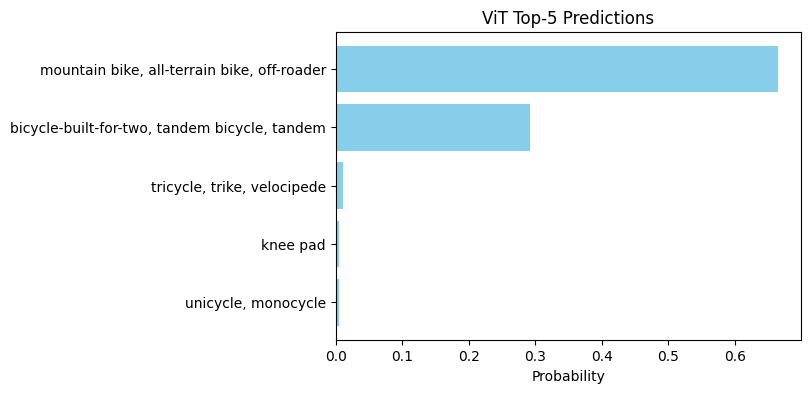

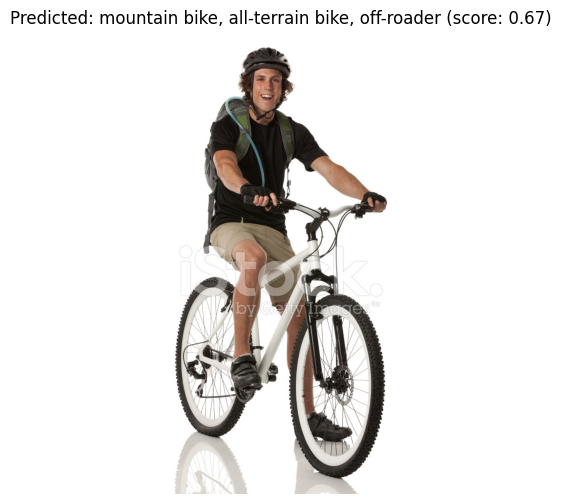

In [11]:
model_name_vit = "google/vit-base-patch16-224"
processor_vit = ViTImageProcessor.from_pretrained(model_name_vit)
model_vit = ViTForImageClassification.from_pretrained(model_name_vit).to(device)

url = "https://images.freeimages.com/images/premium/previews/2093/20938624-mountain-biker.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor_vit(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model_vit(**inputs)

logits = outputs.logits
pred_prob = torch.nn.functional.softmax(logits, dim=1)
top5 = torch.topk(pred_prob, k=5)

# 4) 결과 확인 (Top-5)
labels_top5 = [model_vit.config.id2label[idx.item()] for idx in top5.indices[0]]
scores_top5 = [score.item() for score in top5.values[0]]
for label, score in zip(labels_top5, scores_top5):
    print(f"{label:25s} | 점수: {score:.4f}")

plt.figure(figsize=(6, 4))
plt.barh(labels_top5, scores_top5, color='skyblue')
plt.gca().invert_yaxis()  # 위에서 아래로 높은 점수가 오도록
plt.xlabel("Probability")
plt.title("ViT Top-5 Predictions")
plt.show()

top1_label = labels_top5[0]
top1_score = scores_top5[0]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {top1_label} (score: {top1_score:.2f})")
plt.axis('off')
plt.show()


# 3. BERT (Sentiment Analysis 예시)

BERT는 텍스트 인코더로, 다양한 NLP 태스크에 사용됩니다. 여기서는 간단하게 **감정 분류** 예제를 수행합니다.
Hugging Face의 `pipeline("sentiment-analysis")`를 사용하면 간단히 추론이 가능합니다.

### 구성 순서
1. 감정 분류용 BERT 모델 로드 (예: `nlptown/bert-base-multilingual-uncased-sentiment`)
2. 테스트할 문장 목록 준비
3. 추론 -> 결과(별 1~5) 도출
4. 결과 확인 및 간단 시각화(Bar Chart)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


=== 감정 분석 결과 (별 1~5) ===

문장: 이 제품은 정말 최고야! 너무 마음에 들어.
결과: {'label': '5 stars', 'score': 0.9130706191062927}

문장: 솔직히 별로야. 돈이 아까움.
결과: {'label': '1 star', 'score': 0.42365774512290955}

문장: Just okay, not too good, not too bad.
결과: {'label': '3 stars', 'score': 0.867607831954956}

문장: I absolutely love this! It's fantastic.
결과: {'label': '5 stars', 'score': 0.9735479354858398}

문장: Terrible experience. I hate it.
결과: {'label': '1 star', 'score': 0.8979194760322571}



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


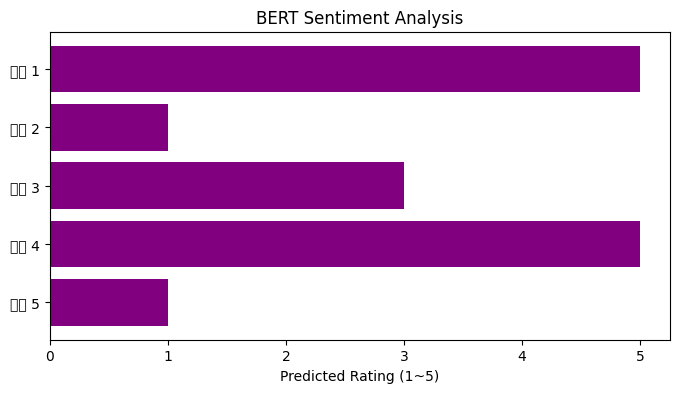

In [7]:
model_name_bert = "nlptown/bert-base-multilingual-uncased-sentiment"
classifier_bert = pipeline("sentiment-analysis", model=model_name_bert, tokenizer=model_name_bert, device=0 if torch.cuda.is_available() else -1)

sentences = [
    "이 제품은 정말 최고야! 너무 마음에 들어.",
    "솔직히 별로야. 돈이 아까움.",
    "Just okay, not too good, not too bad.",
    "I absolutely love this! It's fantastic.",
    "Terrible experience. I hate it."
]

results = classifier_bert(sentences)

print("=== 감정 분석 결과 (별 1~5) ===\n")
for sentence, result in zip(sentences, results):
    print(f"문장: {sentence}")
    print(f"결과: {result}\n")

numeric_labels = [int(res['label'].split()[0]) for res in results]  # '5 stars' -> 5

plt.figure(figsize=(8, 4))
plt.barh(range(len(sentences)), numeric_labels, color='purple')
plt.yticks(range(len(sentences)), [f"문장 {i+1}" for i in range(len(sentences))])
plt.xlabel('Predicted Rating (1~5)')
plt.title('BERT Sentiment Analysis')
plt.gca().invert_yaxis()
plt.show()


# 4. GPT-2 (Text Generation)

GPT-2는 디코더 기반 언어 모델로, **텍스트 생성**에 특화되어 있습니다.
주어진 프롬프트(문장 시작)에 이어서 자연스러운 텍스트를 생성합니다.

### 구성 순서
1. GPT-2 모델 및 토크나이저 로드
2. 프롬프트 정의
3. 파이프라인으로 텍스트 생성
4. 여러 개 샘플 확인

In [8]:
model_name_gpt2 = "gpt2"
gpt2_generator = pipeline(
    "text-generation",
    model=model_name_gpt2,
    tokenizer=model_name_gpt2,
    device=0 if torch.cuda.is_available() else -1
)

prompt = "Once upon a time,"  # 영어 예제

generated_texts = gpt2_generator(
    prompt,
    max_length=50,
    num_return_sequences=3,
    do_sample=True,
    top_k=50,
    top_p=0.95
)

for i, gen in enumerate(generated_texts):
    print(f"[생성 {i+1}] {gen['generated_text']}")
    print("-" * 80)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[생성 1] Once upon a time, as with most stories here, there seems to be a lot of evidence that the world can't get any more "just like it is always doing now" or "this is all the best." It can still do better.
--------------------------------------------------------------------------------
[생성 2] Once upon a time, we were all going home.

"We found a beautiful young man here, called the Maniacs, and had him in our house with our son. He said he was at the bottom of a river about an
--------------------------------------------------------------------------------
[생성 3] Once upon a time, the most successful of the guilds were of course mages. Their name was: the Dark Brotherhood and it was during that time that the Dark Legion led the crusade, bringing death to all and their destruction. After that, many
--------------------------------------------------------------------------------


# 5. DETR (Detection Transformer)

DETR는 **인코더-디코더 구조**를 가진 객체 검출 모델로,
이미지 내 객체 위치(바운딩 박스)와 클래스를 추론합니다.

### 구성 순서
1. `facebook/detr-resnet-50` 모델과 Image Processor 로드
2. 테스트 이미지 로드
3. 모델 추론
4. 바운딩 박스, 클래스, 스코어 추출 후 필터링
5. 시각화 (박스 + 라벨 + 점수)

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


검출된 객체 수(임계값 0.7 이상): 4


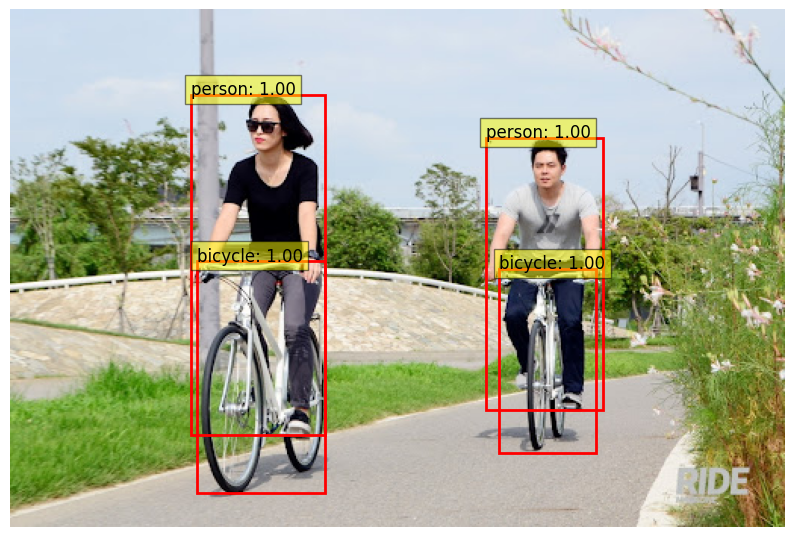

In [9]:
model_name_detr = "facebook/detr-resnet-50"
processor_detr = DetrImageProcessor.from_pretrained(model_name_detr)
model_detr = DetrForObjectDetection.from_pretrained(model_name_detr).to(device)

url_detr = "https://lh6.googleusercontent.com/proxy/VSIJg62xh9VErMvNU9DE6Eo-jsYdBpivT-E0sCmAX1q87Nox1mBVTiFVlEjc5x4eaHTCLR6w48jqq_CKXyCN2EhmRJdjKweXHjIGx7ffs2Bg"  # 예시
image_detr = Image.open(requests.get(url_detr, stream=True).raw)

inputs_detr = processor_detr(images=image_detr, return_tensors="pt").to(device)
with torch.no_grad():
    outputs_detr = model_detr(**inputs_detr)

logits = outputs_detr.logits[0]  # (num_queries, num_classes)
pred_boxes = outputs_detr.pred_boxes[0]  # (num_queries, 4) -> center_x, center_y, w, h

probs = logits.softmax(-1)

probs_no_object = probs[..., :-1]

max_probs, class_ids = probs_no_object.max(dim=-1)

threshold = 0.7
keep = max_probs > threshold

boxes_to_plot = pred_boxes[keep]
scores_to_plot = max_probs[keep]
class_ids_to_plot = class_ids[keep]

print(f"검출된 객체 수(임계값 {threshold} 이상): {len(boxes_to_plot)}")

# 5) 시각화 (matplotlib)
plt.figure(figsize=(10, 10))
plt.imshow(image_detr)
ax = plt.gca()

img_w, img_h = image_detr.size

import matplotlib.patches as patches

for box, score, class_id in zip(boxes_to_plot, scores_to_plot, class_ids_to_plot):
    cx, cy, w, h = box
    # center_x, center_y, width, height -> x1, y1로 변환
    cx, cy, w, h = cx*img_w, cy*img_h, w*img_w, h*img_h
    x1 = cx - 0.5*w
    y1 = cy - 0.5*h

    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    class_name = model_detr.config.id2label[class_id.item()]
    text = f"{class_name}: {score.item():.2f}"
    ax.text(x1, y1, text, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis('off')
plt.show()


# 마무리 멘트

위 예시들을 통해
- **ViT**: 이미지 분류 (인코더)
- **BERT**: 문장 분류 (인코더)
- **GPT-2**: 텍스트 생성 (디코더)
- **DETR**: 객체 검출 (인코더-디코더)

등의 기본 사용법을 확인했습니다.
프로젝트 목적에 따라 **다른 모델**과 **데이터셋**, **Fine-tuning** 과정을 추가하여
더 심도 있는 분석과 모델 활용을 진행하실 수 있습니다.

> - GPU 활용: `.to(device)`로 모델과 텐서를 GPU에 올리면 추론이 훨씬 빨라집니다.
> - Fine-tuning: `Trainer` 또는 PyTorch를 이용해 커스텀 데이터셋에 맞춤 학습이 가능합니다.
> - Preprocessing & Postprocessing: 실제 프로젝트에선 더 세심한 전처리/후처리 절차가 필요합니다.

그간 딥러닝 모델 수업을 수강해주셔서 감사합니다! 화이팅~!